In [1]:
from data_preparation_functions import *
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import warnings
from sklearn import linear_model, tree, discriminant_analysis, naive_bayes, ensemble, gaussian_process
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import log_loss, confusion_matrix
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

## 3. Model Building & Hyperparameter Tuning

This section will look to cover 3 main points:
1. Choosing which Machine Learning algorithm to use from a variety of choices
2. Hyperparameter Tuning
3. Overfitting/Underfitting

### Choosing an Algorithm

The best way to choose an algorithm is to test all of them and decide after reviewing their metrics. <br>
To do this, it is necessary to define a function that iterates over a number of algorithms and gives us an indication of which algorithms are suited to this dataset and exercise.

In [2]:
features = create_feature_df()

Creating all games feature DataFrame
Creating stats feature DataFrame
Creating odds feature DataFrame
Creating market values feature DataFrame
Filling NAs
Merging stats, odds and market values into one features DataFrame
Complete.


In [3]:
features

,Date,gameId,HomeTeam,season,f_homeWinPc38Home,f_homeWinPc5Home,f_awayWinPc38Home,f_awayWinPc5Home,f_eloForHome,f_eloAgainstHome,f_wtEloGoalsForHome,f_wtEloGoalsAgainstHome,f_cornersAgainstHome,f_cornersForHome,f_freesAgainstHome,f_freesForHome,f_goalsAgainstHome,f_goalsForHome,f_halfTimeGoalsAgainstHome,f_halfTimeGoalsForHome,f_redsAgainstHome,f_redsForHome,f_shotsAgainstHome,f_shotsForHome,f_shotsOnTargetAgainstHome,f_shotsOnTargetForHome,f_yellowsAgainstHome,f_yellowsForHome,f_avAsianHandicapOddsAgainstHome,f_avAsianHandicapOddsForHome,f_avgreaterthan2.5Home,f_avlessthan2.5Home,f_sizeOfHandicapHome,AwayTeam,f_homeWinPc38Away,f_homeWinPc5Away,f_awayWinPc38Away,f_awayWinPc5Away,f_eloForAway,f_eloAgainstAway,f_wtEloGoalsForAway,f_wtEloGoalsAgainstAway,f_cornersAgainstAway,f_cornersForAway,f_freesAgainstAway,f_freesForAway,f_goalsAgainstAway,f_goalsForAway,f_halfTimeGoalsAgainstAway,f_halfTimeGoalsForAway,f_redsAgainstAway,f_redsForAway,f_shotsAgainstAway,f_shotsForAway,f_shotsOnTargetAgainstAway,f_shotsOnTargetForAway,f_yellowsAgainstAway,f_yellowsForAway,f_avAsianHandicapOddsAgainstAway,f_avAsianHandicapOddsForAway,f_avgreaterthan2.5Away,f_avlessthan2.5Away,f_sizeOfHandicapAway,f_attMktH%,f_attMktA%,f_midMktH%,f_midMktA%,f_defMktH%,f_defMktA%,f_gkMktH%,f_gkMktA%,f_totalMktH%,f_totalMktA%,result,f_awayOdds,f_drawOdds,f_homeOdds
20,2005-08-23,21,Birmingham,0506,0.394737,0.4,0.263158,0.2,1478.687038,1492.866048,1.061763,1.260223,4.979592,7.530612,12.000000,9.938776,1.020408,0.510204,0.510204,0.510204,0.000000,0.000000,11.938776,8.020408,6.489796,2.979592,1.000000,2.510204,1.909000,1.945500,2.051000,1.673500,-0.137500,Middlesbrough,0.394737,0.4,0.263158,0.2,1492.866048,1478.687038,1.129940,1.279873,2.551020,5.510204,13.551020,13.428571,1.020408,0.000000,0.000000,0.000000,0.000000,0.489796,17.020408,8.081633,7.510204,2.510204,3.000000,1.489796,1.939500,1.909500,2.003500,1.715500,0.387500,5.132983,5.260851,3.341048,4.289788,3.502318,4.168935,2.332815,3.216457,3.934396,4.522205,away,2.75,3.20,2.50
21,2005-08-23,22,Portsmouth,0506,0.447368,0.4,0.263158,0.4,1405.968416,1489.229314,1.147101,1.503051,2.510204,4.959184,21.979592,16.061224,2.000000,0.510204,1.000000,0.000000,0.000000,0.000000,8.448980,10.489796,3.959184,4.448980,3.020408,1.530612,1.896500,1.969000,2.004000,1.700500,0.250000,Aston Villa,0.447368,0.4,0.263158,0.4,1489.229314,1405.968416,1.175160,1.263229,9.530612,7.000000,14.469388,17.571429,1.489796,0.979592,0.979592,0.979592,0.000000,0.000000,15.551020,3.000000,9.061224,2.510204,2.000000,0.510204,1.856500,1.977000,1.850500,1.848500,0.712500,3.738614,3.878659,4.494368,4.954673,2.884262,4.065926,3.746642,5.372543,3.743410,4.365456,draw,2.75,3.20,2.50
22,2005-08-23,23,Sunderland,0506,0.236842,0.0,0.236842,0.4,1277.888970,1552.291880,0.650176,1.543716,5.000000,5.000000,12.408163,17.551020,1.979592,0.489796,1.000000,0.489796,0.489796,0.510204,14.510204,6.897959,5.020408,3.918367,1.020408,2.510204,1.852000,1.991500,1.853500,1.850000,0.712500,Man City,0.236842,0.0,0.236842,0.4,1552.291880,1277.888970,1.288750,1.287367,7.530612,3.510204,8.959184,12.489796,0.510204,1.020408,0.510204,0.510204,0.000000,0.000000,10.959184,11.938776,2.489796,6.979592,3.000000,1.489796,1.815000,2.039500,2.006000,1.709500,-0.200000,0.706318,3.750792,1.476812,1.070209,2.634096,4.455890,0.777605,4.913050,1.499427,3.151477,away,2.50,3.20,2.75
23,2005-08-24,24,Arsenal,0506,0.736842,1.0,0.236842,0.2,1729.086068,1481.943781,2.099593,0.921523,3.000000,7.489796,17.000000,18.061224,0.510204,0.979592,0.000000,0.000000,0.489796,0.000000,5.571429,11.938776,3.551020,7.408163,1.510204,1.530612,1.945500,1.909000,1.876000,1.828500,-0.287500,Fulham,0.736842,1.0,0.236842,0.2,1481.943781,1729.086068,1.170928,1.323440,7.020408,3.448980,19.632653,13.020408,1.020408,0.510204,0.510204,0.000000,0.000000,0.000000,11.591837,11.428571,6.551020,5.469388,2.000000,1.510204,2.061000,1.799000,2.023500,1.684500,0.275000,10.807882,0.785474,8.064289,4.161925,9.116327,3.583254,3.661813,5.

To start our modelling process, we need to make a training set, a test set and a holdout set. <br>
<br>
As we are using cross validation, we will make our training set all of the seasons up until 2017/18, and we will use the 2017/18 season as the test set.

In [4]:
feature_list = [col for col in features.columns if col.startswith("f_")]

le = LabelEncoder() # initiate a label encoder to transform the labels 'away', 'draw', 'home' to 0,1,2

# Grab all seasons except for 2017/18 to use cross validation with
all_x = features.loc[features.season != '17/18', ['gameId'] + feature_list]
all_y = features.loc[features.season != '17/18', 'result']
all_y = le.fit_transform(all_y)

train_x = features.loc[~features.season.isin(['16/17', '17/18']), ['gameId'] + feature_list]
train_y = le.transform(features.loc[~features.season.isin(['16/17', '17/18']), 'result'])

holdout_x = features.loc[features.season == '16/17', ['gameId'] + feature_list]
holdout_y = le.transform(features.loc[features.season == '16/17', 'result'])

test_x = features.loc[features.season == '17/18', ['gameId'] + feature_list]
test_y = le.transform(features.loc[features.season == '17/18', 'result'])

In [5]:
# Create a list of standard classifiers
classifiers = [

    #GLM
    linear_model.LogisticRegressionCV(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
#     xgb.XGBClassifier()    
]

In [6]:
def find_best_algorithms(classifier_list, X, y):
    # This function is adapted from https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
    kfold = StratifiedKFold(n_splits=5)
    
    cv_results = [cross_val_score(classifier, X, y, scoring = "neg_log_loss", cv = kfold) for classifier in classifier_list]
    cv_means = [cv_result.mean() * -1 for cv_result in cv_results]
    cv_std = [cv_result.std() for cv_result in cv_results]
    algorithm_names = [alg.__class__.__name__ for alg in classifiers]
    
    # create a dataframe of all the CV results
    cv_results = pd.DataFrame({
        "Mean Log Loss": cv_means,
        "Log Loss Std": cv_std,
        "Algorithm": algorithm_names
    }).sort_values(by="Mean Log Loss")
    return cv_results

In [7]:
algorithm_results = find_best_algorithms(classifiers, all_x, all_y)

In [8]:
algorithm_results

,Mean Log Loss,Log Loss Std,Algorithm
0,0.965229,0.011466,LogisticRegressionCV
7,0.996645,0.019931,ExtraTreesClassifier
9,0.999708,0.015659,RandomForestClassifier
1,1.015792,0.010107,BernoulliNB
3,1.043758,0.097858,LinearDiscriminantAnalysis
8,1.081107,0.102342,GradientBoostingClassifier
5,1.092277,0.005261,AdaBoostClassifier
10,1.098612,0.000000,GaussianProcessClassifier
6,2.218542,0.223842,BaggingClassifier
4,5.394628,4.239353,QuadraticDiscriminantAnalysis


We can see that the LogisticRegression seems to perform the best out of all the algorithms, and some algorithms have a very high log loss. <br>
This is most likely due to overfitting. It would definitely be useful to condense our features down to reduce the dimensionality of the dataset.

## Hyperparameter Tuning

Since it was best performing, we will use logistic regression. I will first try to fine tune a logistic regression model with cross validation, using grid search. 
* Grid search essentially tries out each combination of values and finds the model with the lowest error metric, which in our case is log loss.
* 'C' in logistic regression determines the amount of regularisation.
* Lower values increase regularisation.

In [9]:
# Define our parameters to run a grid search over
lr_grid = {
    "C": [0.0001, 0.01, 0.05, 0.2, 1],
    "solver": ["newton-cg", "lbfgs", "liblinear"]
}

kfold = StratifiedKFold(n_splits=5)

gs = GridSearchCV(LogisticRegression(), param_grid=lr_grid, cv=kfold, scoring='neg_log_loss')
gs.fit(all_x, all_y)
print("Best log loss: {}".format(gs.best_score_ *-1))
best_lr_params = gs.best_params_

Best log loss: 0.9638207733217344


## Defining a Baseline

It is necessary at this point to define a baseline, as we don't really know if the log loss is good or bad. <br>
<br>
Randomly assigning a 1/3 chance to each selection yields a log loss of log(3) = 1.09.

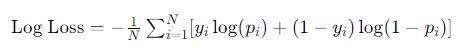

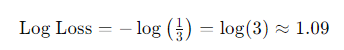

However, we are most interested in how the model performs relative to the odds. 
<br><br>
Important to find the log loss of the odds.

In [10]:
# Finding the log loss of the odds
log_loss(all_y, 1 / all_x[['f_awayOdds', 'f_drawOdds', 'f_homeOdds']])

0.9580387769719025

Good news as this algorithm almost beats the bookies in terms of log loss - Goal to try beat this result.

## Analysing the Errors Made

Important to analyse the type of errors that have been made.
<br>
To do this, we will look at the confusion matrix produced when we predict our holdout set.

In [11]:
lr = LogisticRegression(**best_lr_params) # Instantiate the model
lr.fit(train_x, train_y) # Fit our model
lr_predict = lr.predict(holdout_x)

ValueError: Found array with 0 sample(s) (shape=(0, 72)) while a minimum of 1 is required by LogisticRegression.

In [ ]:
# Construct a confusion matrix
c_matrix = (pd.DataFrame(confusion_matrix(holdout_y, lr_predict), columns=le.classes_, index=le.classes_))